# ADMA Report 1 Experiment

Used datasets:

- Fashion MNIST

    H. Xiao, K. Rasul and R. Vollgraf.(2017). Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
Algorithms (cite arxiv:1708.07747Comment: Dataset is freely available at https://github.com/zalandoresearch/fashion-mnist Benchmark is available at http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/)

- [Muffin vs Chihuahua](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/data)
    
    E. Togootogtokh, and A. Amartuvshin.(2018). Deep Learning Approach for Very Similar Objects Recognition Application on Chihuahua and Muffin Problem. (10.48550/arXiv.1801.09573.)

- [A Large Scale Fish Dataset](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset/versions/2)

    O.Ulucan, D.Karakaya, and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification. In Conf. Innovations Intell. Syst. Appli. (ASYU)
    
    ^^^ I can't access this paper (found on IEEE, it says this paper is outside of my subscription, even though the site notifies me I have access provided by the university). I found instead another paper that references it:
    
    Dey, Kohav & Bajaj, Krishna & Ramalakshmi, K & Thomas, Samuel & Radhakrishna, Sriram. (2023). FisHook - An Optimized Approach to Marine Species Classification using MobileNetV2. 1-7. 10.1109/OCEANSLimerick52467.2023.10244558. 


In [1]:
import tensorflow as tf, numpy as np, cv2, os, gc
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sn
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
import scipy.ndimage as nd
import scipy.ndimage.filters as filters

## Loading Scripts

In [2]:
class LabelsData:
    def __init__(self, aliases={}):
        self.name2id = {}
        self.id2name = {}
        self.aliases = aliases
        self.num_classes = 0
        self.classes = []
    
    def add_new_label(self, name):
        new_id = self.num_classes
        self.name2id[name] = new_id
        self.id2name[new_id] = name
        self.num_classes+=1
        self.classes.append(name)
    
    def get_label_id_by_name(self, name):
        if name in self.aliases: name = self.aliases[name]
        if not name in self.name2id:
            self.add_new_label(name)
        return self.name2id[name]
    
    def get_label_name_by_id(self, _id): return self.id2name[_id]    
    
    def set_labels(self, labels):
        for label in labels: self.add_new_label(label)

In [3]:
class DatasetLoadingParams:
    def __init__(self, path, labels_data, label_from_path_fun = None, img_size=(224,244), path_filter=None):
        self.path = path
        self.labels_data = labels_data
        self.label_from_path_fun = label_from_path_fun
        if self.label_from_path_fun is None:
            self.label_from_path_fun = lambda relpath: os.path.dirname(relpath)
        self.path_filter = path_filter if path_filter is not None else lambda path:True
        self.img_size = img_size

In [4]:
def is_image_file_format(path):
    return path.endswith('.png') or path.endswith('.jpg') or path.endswith('.jpeg')

In [5]:
fish_loading_params = DatasetLoadingParams(
    path= "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset",
    labels_data = LabelsData(aliases={
        'Hourse Mackerel': 'Horse Mackerel', 'Gilt Head Bream':'Gilt-Head Bream'
    }),
    label_from_path_fun = lambda relpath: relpath.split('/')[0],
    path_filter = lambda path: is_image_file_format(path) and not " GT" in path,
    img_size=(224-32,224-32)
)

In [6]:
pet_loading_params = DatasetLoadingParams(
    path= "/kaggle/input/the-oxfordiiit-pet-dataset/images",
    labels_data = LabelsData(),
    label_from_path_fun = lambda relpath: '_'.join(relpath.split('_')[:-1]).lower(),
    path_filter = lambda path: is_image_file_format(path) and not 'images/images' in path,
    img_size=(224,224)
)

In [7]:
muff_chiu_loading_params = DatasetLoadingParams(
    path= "/kaggle/input/muffin-vs-chihuahua-image-classification/train",
    labels_data = LabelsData(),
    label_from_path_fun = lambda relpath: relpath.split('/')[0],
    path_filter = lambda path: is_image_file_format(path),
    img_size=(160, 160)
)

In [8]:
def load_labeled_folders(loading_params, custom_path = None, img_proc=None):
    path = loading_params.path if custom_path is None else custom_path
    xs, ys = [], []
    for root, dirs, files in os.walk(path):
        for file in files:
            in_path = os.path.join(root, file)
            if not loading_params.path_filter(in_path):                
                continue                  
            
            label_name = loading_params.label_from_path_fun(os.path.relpath(in_path, path))            
            
            error=False
            try:
                x = cv2.imread(in_path)[...,::-1]                
            except:
                error = True
            if not error:
                if img_proc is not None: x = img_proc(x)
                x = cv2.resize(x, loading_params.img_size, interpolation=cv2.INTER_AREA)                
                y = loading_params.labels_data.get_label_id_by_name(label_name)
                xs.append((x/255.).astype(np.float32))
                ys.append(y)                        
        print(f"\r {root}\t\t\t", end="")
    return np.array(xs), np.array(ys)

In [9]:
#x_train, y_train = load_labeled_folders(pet_loading_params)

In [10]:
#x_train.shape, y_train.shape, pet_loading_params.labels_data.num_classes

In [11]:
def show_img_and_classes(x, y, indices, labels_data):
    x, y = x[indices], y[indices]
    fig, ax = plt.subplots(1, len(x), figsize=(10, 10*len(x)))
    for i in range(len(x)):
        ax[i].axis('off'); ax[i].imshow(x[i])
        ax[i].set_title(labels_data.get_label_name_by_id(y[i]))
    plt.show()

In [12]:
def show_imgs(x):    
    fig, ax = plt.subplots(1, len(x), figsize=(10, 10*len(x)))
    for i in range(len(x)):
        ax[i].axis('off'); ax[i].imshow(x[i])        
    plt.show()

In [13]:
def show_conf_mat(y_true, y_pred, classes):
    conf_mat = tf.math.confusion_matrix(y_true, y_pred).numpy()

    df_cm = pd.DataFrame(conf_mat, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

## Metrics

In [14]:
def normalized_stress(x, r, dx=None, dr=None, alpha=1, eps=1e-5):
    print("Computing normalized_stress")
    dx = pdist(x[:5000]) if dx is None else dx
    dr = pdist(r[:5000]) if dr is None else dr
    d0 = np.sum((dx-alpha*dr)**2)
    d1 = np.sum(dx**2)
    return np.sqrt(d0/d1)

In [15]:
def shepard_goodness(x, r, dx=None, dr=None):
    print("Computing shepard_goodness")
    dx = pdist(x[:5000]) if dx is None else dx
    dr = pdist(r[:5000]) if dr is None else dr
    s = spearmanr(dx, dr)
    return s.statistic    

In [16]:
def scale_normalized_stress(x,r, dx=None, dr=None):        
    print("Computing SNS")
    dx = pdist(x[:5000]) if dx is None else dx
    dr = pdist(r[:5000]) if dr is None else dr
    alpha = np.sum(dx*dr) / np.sum(dr**2)
    d0 = np.sum((dx-alpha*dr)**2)
    d1 = np.sum(dx**2)
    return np.sqrt(d0/d1)

In [17]:
 def kruskal_stress(x, r, dx, dr):        
        print("Computing Kruskal non-metric stress")
        dx = pdist(x[:5000]) if dx is None else dx
        dr = pdist(r[:5000]) if dr is None else dr        

        sorted_indices = np.argsort(dx)
        dx = dx[sorted_indices]
        dr = dr[sorted_indices]
        del sorted_indices

        from sklearn.isotonic import IsotonicRegression
        hij = IsotonicRegression().fit(dx, dr).predict(dx)

        raw_stress = np.sum(np.square(dr - hij))
        norm_factor = np.sum(np.square(dr))

        stress = np.sqrt(raw_stress / norm_factor)
        return stress

In [18]:
CLUSTER_METRICS = [normalized_stress, shepard_goodness, scale_normalized_stress, kruskal_stress]

In [19]:
class Experiment:
    def __init__(self, loading_params, data_loader = None, max_perceptual_layer = 5, ae_epochs=10, latent_dim=2048, lr=1e-2):
        tf.keras.backend.clear_session(True)
        self.loading_params = loading_params
        self.input_size = (*loading_params.img_size[::-1], 3)
        self.max_perceptual_layer = max_perceptual_layer
        self.ae_epochs = ae_epochs
        self.latent_dim = latent_dim
        self.encoder, self.decoder, self.autoencoder = self.__create_autoencoder__()        
        self.lr = lr
        
        if data_loader is None: data_loader = Experiment.__loader_folders_train_test_split__
        
        self.x_train, self.y_train, self.x_test, self.y_test = data_loader(self.loading_params)
        self.num_classes = loading_params.labels_data.num_classes
        self.on_tsne_plot = None
        
    @staticmethod
    def __loader_folders_train_test_split__(loading_params):
        x, y = load_labeled_folders(loading_params)
        indices = np.array(range(len(x)))
        np.random.shuffle(indices)
        x, y = x[indices], y[indices]
        split_index = int(len(x)*0.9)
        return x[:split_index], y[:split_index], x[split_index:], y[split_index:]
    
    @staticmethod
    def loader_folders_separate_test(test_path, test_proc=None):
        def fun(loading_params):
            x_train, y_train = load_labeled_folders(loading_params)            
            indices = np.array(range(len(x_train)))
            np.random.shuffle(indices)
            x_train, y_train = x_train[indices], y_train[indices]
            x_test, y_test = load_labeled_folders(loading_params, custom_path=test_path, img_proc=test_proc)
            indices = np.array(range(len(x_test)))
            np.random.shuffle(indices)
            x_test, y_test = x_test[indices], y_test[indices]
            return x_train, y_train, x_test, y_test
        return fun
        
        
    def __create_autoencoder__(self):
        assert(self.input_size[0]%32==0)
        assert(self.input_size[1]%32==0)
        conv_cfg = {'kernel_size':(3,3), 'padding':'same', 'activation':'leaky_relu'}        
        
        encoder = tf.keras.models.Sequential([
            tf.keras.layers.Input(self.input_size),
            
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(32, **conv_cfg),
            tf.keras.layers.Conv2D(32, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(64, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(128, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(256, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Conv2D(512, **conv_cfg),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.latent_dim, activation="tanh"),
        ])
        
        h,w,_ = self.input_size
        h//=32; w//=32; c=512
        
        decoder = tf.keras.models.Sequential([
            tf.keras.layers.Input(encoder.outputs[0].shape[1:]),
            
            tf.keras.layers.Dense(h*w*c, activation="leaky_relu"),
            tf.keras.layers.Reshape((h,w,c)),
            
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(256, **conv_cfg),
            
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(128, **conv_cfg),
            
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(64, **conv_cfg),
            
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(32, **conv_cfg),
            tf.keras.layers.Conv2D(32, **conv_cfg),
            
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.Conv2D(16, **conv_cfg),
                        
            tf.keras.layers.Conv2D(3, kernel_size=(1,1), padding="same", activation="hard_sigmoid"),
        ])
        
        autoencoder = tf.keras.models.Sequential([
            tf.keras.layers.Input(self.input_size),
            encoder,
            decoder
        ])
        
        return encoder, decoder, autoencoder
    
    def __create_classifier__(self):
        conv_cfg = {'kernel_size':(3,3), 'padding':'same', 'activation':'leaky_relu'}
        return tf.keras.models.Sequential([
            tf.keras.layers.Input(self.input_size),
            tf.keras.layers.Conv2D(16, **conv_cfg),
            tf.keras.layers.Conv2D(16, **conv_cfg),            
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(32, **conv_cfg),            
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(64, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(128, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.Conv2D(256, **conv_cfg),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Conv2D(512, **conv_cfg),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.num_classes, activation="softmax")
        ])
    
    def view_tsne(self, tsne, y_true, classes):
        if len(y_true)>10000:
            tsne = tsne[:10000]
            y_true = y_true[:10000]
        def scale_to_01_range(x):
            value_range = (np.max(x) - np.min(x))
            starts_from_zero = x - np.min(x)
            return starts_from_zero / value_range

        tx = scale_to_01_range(tsne[:, 0])
        ty = scale_to_01_range(tsne[:, 1])        

        colors = ['red', 'blue', 'green', 'brown', 'yellow', "black", "magenta", "cyan", "lime", 'orange']        
        
        if len(colors)>len(classes):
            colors = colors[:len(classes)]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.tick_params(axis='x', labelrotation=45)        
        for idx, c in enumerate(colors):
            indices = [i for i, l in enumerate(y_true) if idx == l]
            current_tx = np.take(tx, indices)
            current_ty = np.take(ty, indices)
            ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

        ax.legend(loc='best')
        plt.show()
        
    def run_tsne(self, x, y):
        labels_data = self.loading_params.labels_data
        classes = np.array(labels_data.classes)
        x = x.reshape((len(x), -1))
        tsne = TSNE(n_components=2, perplexity=100).fit_transform(x)
        self.view_tsne(tsne, y, classes)
        dx = pdist(x[:10000])
        dr = pdist(tsne[:10000])
        
        plt.scatter(dx[:5000], dr[:5000], c='#000000')
        plt.title("Shepard diagram")
        plt.xlabel("Original distances")
        plt.ylabel("Embedded distances")
        plt.show()
        
        for metric in CLUSTER_METRICS:
            m = metric(x, tsne, dx, dr)
            print(m)
        del dx, dr
        if self.on_tsne_plot is not None: self.on_tsne_plot(tsne, x, y, classes)
    
    def run(self):
        print(f"Training set samples (shapes: {self.x_train.shape, self.y_train.shape})")
        show_img_and_classes(self.x_train, self.y_train, 
                             np.random.randint(0, len(self.x_train), (6,)), self.loading_params.labels_data)
        
        print(f"Test set samples (shapes: {self.x_test.shape, self.y_test.shape})")
        show_img_and_classes(self.x_test, self.y_test, 
                             np.random.randint(0, len(self.x_test), (6,)), self.loading_params.labels_data)
        
        labels_data = self.loading_params.labels_data
        
        classes = np.array(labels_data.classes)
        
        plt.title("Labels distributions")
        plt.hist([classes[self.y_train], classes[self.y_test]], label=["train","test"])
        plt.legend()
        plt.show()
        
        print("Running autoencoder")        
        
        def create_perceptual_model():            
            model = tf.keras.Sequential(tf.keras.applications.VGG16(include_top = False).layers[:self.max_perceptual_layer])
            return model
        perceptual_model = create_perceptual_model()
        
        def perceptual_loss(y_true, y_pred):
            if self.max_perceptual_layer==1:
                return tf.keras.losses.MSE(y_true, y_pred)
            p_true = perceptual_model(y_true)
            p_pred = perceptual_model(y_pred)
            return tf.keras.losses.MSE(p_true, p_pred)
        
        self.autoencoder.summary()
        
        def ae_loss(y_true, y_pred):
            l = perceptual_loss(y_true, y_pred)
            w = 10
            ssim = w * tf.image.ssim(y_true, y_pred, 1)
            return tf.reduce_sum(l, axis=[1,2]) + ssim
        
        opt = tf.keras.optimizers.Adam(learning_rate=self.lr)
        #self.autoencoder.compile(optimizer="Adam", loss=perceptual_loss)
        self.autoencoder.compile(optimizer=opt, loss=ae_loss)
        history = self.autoencoder.fit(self.x_train, self.x_train, 
                                    epochs=self.ae_epochs, batch_size = 16,
                                    validation_data=(self.x_test, self.x_test))
        
        def plot_ae_history(history):    
            plt.plot(history.history['loss'], label='loss')
            plt.plot(history.history['val_loss'], label='val_loss')
            plt.show()

        plot_ae_history(history)
        del history
        
        
        print("Autoencoder test samples:")
        show_imgs(self.x_test[5:10])
        show_imgs(self.autoencoder(self.x_test[5:10]).numpy())
        
        gc.collect()
        
        print("TSNE")
        z_train = self.encoder.predict(self.x_train)
        self.run_tsne(z_train, self.y_train)        
        del z_train, perceptual_model
        gc.collect()
        
        
        print("TSNE - VGG feedback")
        vgg_embedder = tf.keras.Sequential(tf.keras.applications.VGG16(include_top = False).layers[:-3])        
        z_train = vgg_embedder.predict(self.x_train)
        self.run_tsne(z_train, self.y_train)        
        del z_train, vgg_embedder
        gc.collect()
        
        print("Classification")
        
        self.classifier = self.__create_classifier__()
        self.classifier.summary()
        
        y_cat_train = tf.keras.utils.to_categorical(self.y_train, num_classes = self.num_classes)
        y_cat_test = tf.keras.utils.to_categorical(self.y_test, num_classes = self.num_classes)
        
        cls_opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.classifier.compile(cls_opt, "categorical_crossentropy", metrics=["accuracy"])
        history = self.classifier.fit(self.x_train, y_cat_train, 
                                      epochs=10, batch_size=16, 
                                      validation_data=(self.x_test, y_cat_test))
        del y_cat_train, y_cat_test
        
        def plot_cls_history(history): 
            fig, axis = plt.subplots(1,2, figsize=(10, 5))
            axis[0].plot(history.history['loss'], label='loss')
            axis[0].plot(history.history['val_loss'], label='val_loss')
            axis[0].legend()
            axis[1].plot(history.history['accuracy'], label='accuracy')
            axis[1].plot(history.history['val_accuracy'], label='val_accuracy')
            axis[1].legend()
            plt.show()
        
        plot_cls_history(history)
        
        y_true = self.y_test
        y_pred = np.argmax(self.classifier.predict(self.x_test), axis=-1)
        
        show_conf_mat(y_true, y_pred, self.loading_params.labels_data.classes)
        
        del y_pred
        gc.collect()        
            

        embedder = tf.keras.models.Sequential(self.classifier.layers[:-2])
    
        print("Classifier embeddings TSNE - train")
        z_train = embedder.predict(self.x_train)
        self.run_tsne(z_train, self.y_train)        
        del z_train
        gc.collect()
        
        print("Classifier embeddings TSNE - test")
        z_test = embedder.predict(self.x_test)
        self.run_tsne(z_test, self.y_test)        
        del z_test
        gc.collect()


## Fashion MNIST

In [20]:
fashion_mnist_loading_params = DatasetLoadingParams(
    path= "",
    labels_data = LabelsData(),    
    img_size=(32,32)
)

fashion_mnist_loading_params.labels_data.set_labels([
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
])

In [21]:
def fashion_mnist_load_dataset(loading_params):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()    
    x_train = np.pad(x_train, ((0,0),(2,2),(2,2)), mode="constant", constant_values=0) / 255.
    x_test = np.pad(x_test, ((0,0),(2,2),(2,2)), mode="constant", constant_values=0) / 255.
    x_train = np.stack([x_train, x_train, x_train], axis=-1)
    x_test = np.stack([x_test, x_test, x_test], axis=-1)
    return x_train, y_train, x_test, y_test

In [22]:
e = Experiment(fashion_mnist_loading_params, 
               data_loader = fashion_mnist_load_dataset,
              max_perceptual_layer=1,
              ae_epochs=3,
              latent_dim=128,
              lr = 1e-4)
tsne, x, y, classes = None, None, None, None
def capture_tsne(_tsne, _x, _y, _classes):
    print("capture!")
    global tsne, x, y, classes
    tsne, x, y, classes = _tsne, _x, _y, _classes
e.on_tsne_plot = capture_tsne

Training set samples (shapes: ((60000, 32, 32, 3), (60000,)))


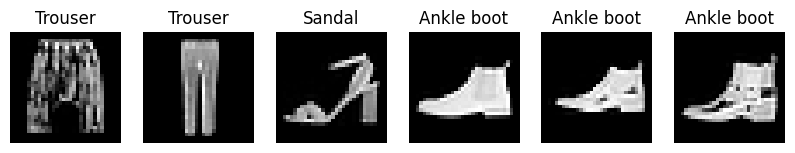

Test set samples (shapes: ((10000, 32, 32, 3), (10000,)))


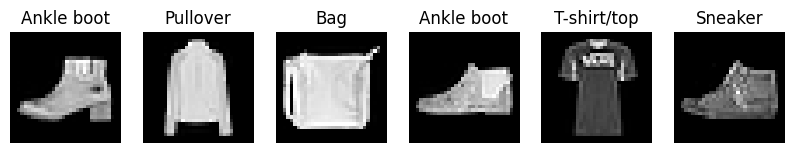

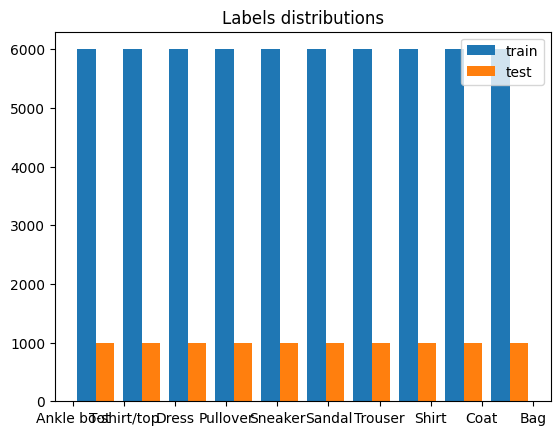

Running autoencoder


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128)            │     1,654,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │     1,654,131 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,771 (12.62 MB)

 Trainable params: 3,308,771 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


I0000 00:00:1731752001.355151    2756 service.cc:145] XLA service 0x7bd9c0002ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731752001.355207    2756 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1731752001.776166    2756 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert/Assert
W0000 00:00:1731752001.776260    2756 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_1/Assert
W0000 00:00:1731752001.777118    2756 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_2/Assert
W0000 00:00:1731752001.777334    2756 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_3/Assert


  23/3750 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 193.9251 

I0000 00:00:1731752005.893899    2756 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3747/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49.3686

W0000 00:00:1731752033.707605    2757 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert/Assert
W0000 00:00:1731752033.707701    2757 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_1/Assert
W0000 00:00:1731752033.708447    2757 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_2/Assert
W0000 00:00:1731752033.708639    2757 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_3/Assert


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 49.3495 - val_loss: 21.8617
Epoch 2/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 21.1708 - val_loss: 19.7691
Epoch 3/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 19.2823 - val_loss: 18.3577


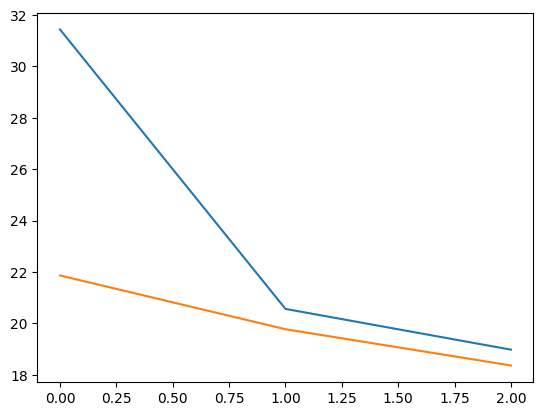

Autoencoder test samples:


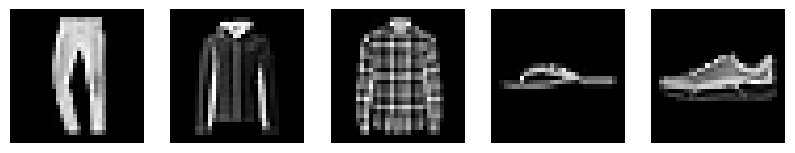

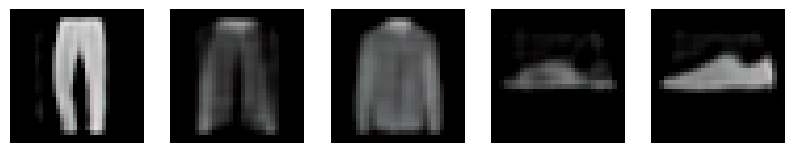

TSNE
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


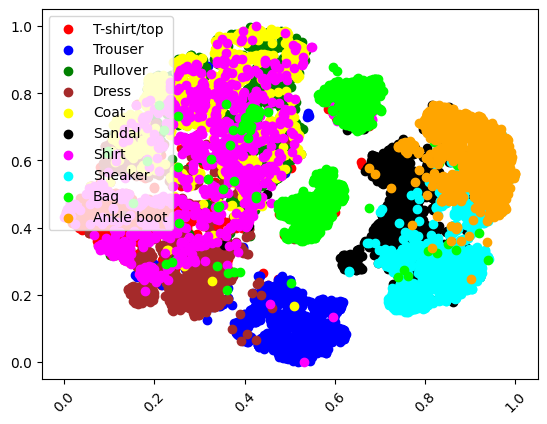

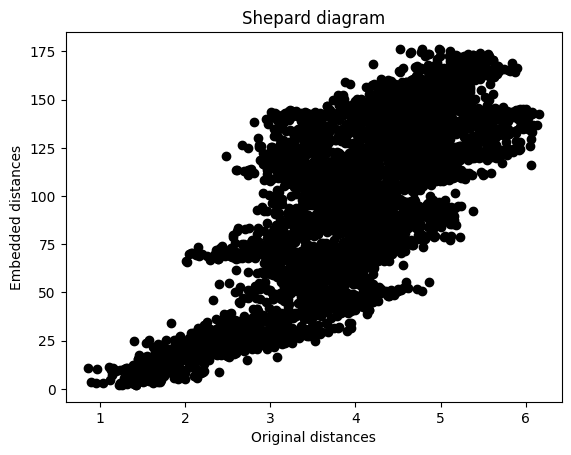

Computing normalized_stress
22.710590628975027
Computing shepard_goodness
0.6678451950721637
Computing SNS
0.31148360075584797
Computing Kruskal non-metric stress
0.3077040317972325
capture!
TSNE - VGG feedback
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


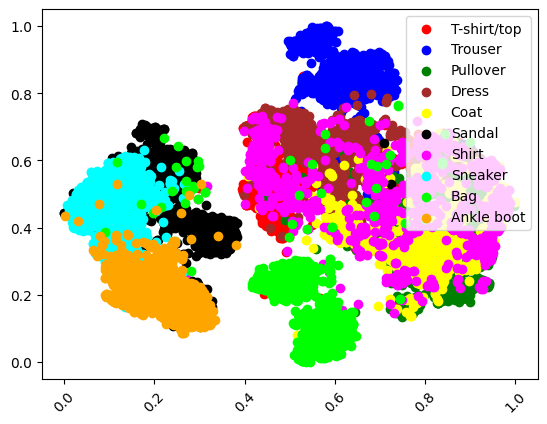

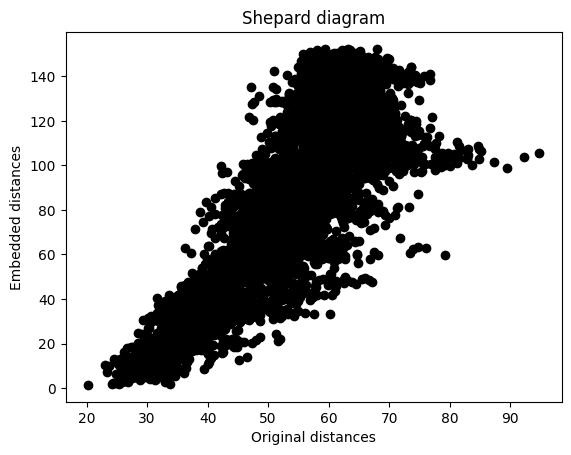

Computing normalized_stress
0.5895641489610617
Computing shepard_goodness
0.4481663698930135
Computing SNS
0.3838370165864203
Computing Kruskal non-metric stress
0.3692541462326608
capture!
Classification


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 1, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,580,218 (6.03 MB)

 Trainable params: 1,580,218 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7693 - loss: 0.6073 - val_accuracy: 0.8813 - val_loss: 0.3336
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8979 - loss: 0.2805 - val_accuracy: 0.9017 - val_loss: 0.2763
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9158 - loss: 0.2349 - val_accuracy: 0.9087 - val_loss: 0.2506
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9255 - loss: 0.2012 - val_accuracy: 0.9058 - val_loss: 0.2632
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9319 - loss: 0.1805 - val_accuracy: 0.9068 - val_loss: 0.2787
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9400 - loss: 0.1595 - val_accuracy: 0.9162 - val_loss: 0.2797
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9451 - loss: 0.1465 - val_accuracy: 0.9147 - val_loss: 0.2728
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9502 - loss: 0

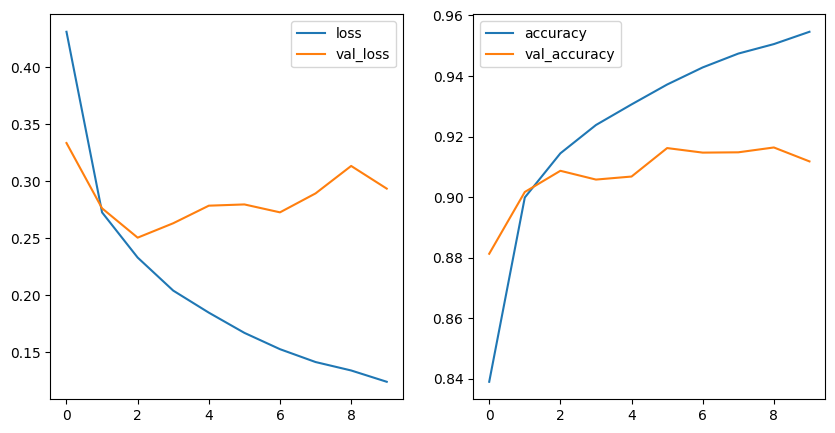

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


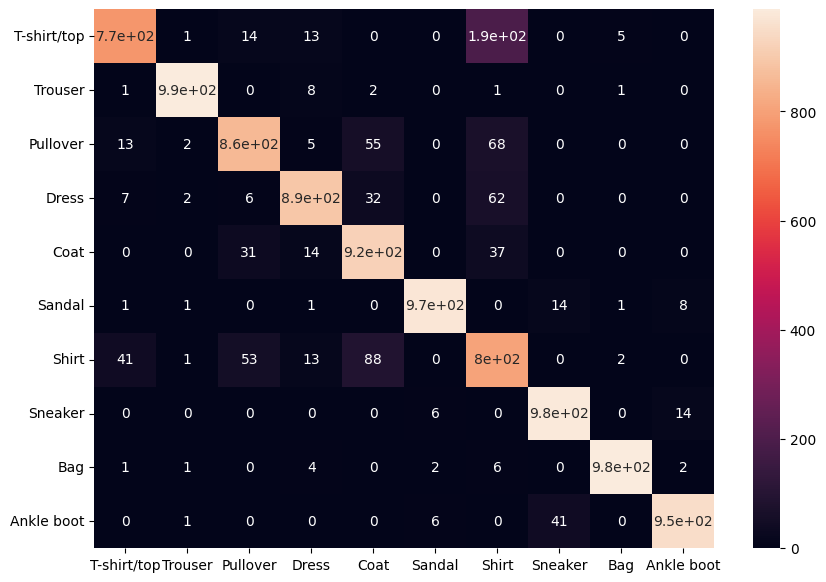

Classifier embeddings TSNE - train
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


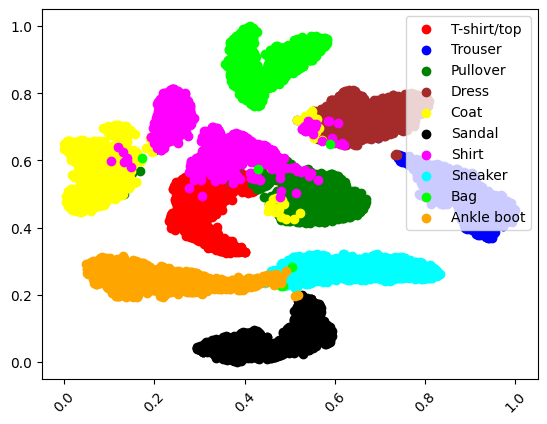

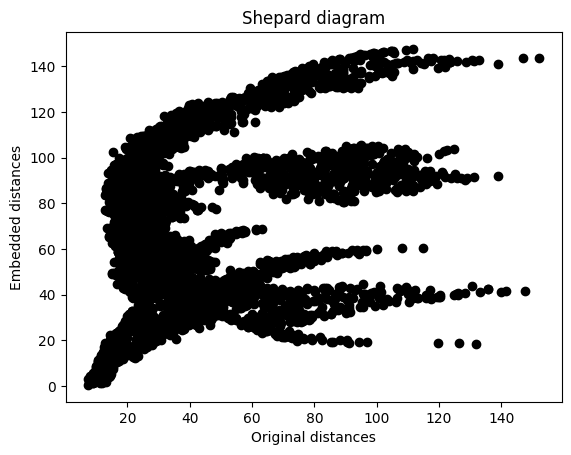

Computing normalized_stress
0.5829505917843374
Computing shepard_goodness
0.5244922756288246
Computing SNS
0.42463076515342785
Computing Kruskal non-metric stress
0.35631478775422765
capture!
Classifier embeddings TSNE - test
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


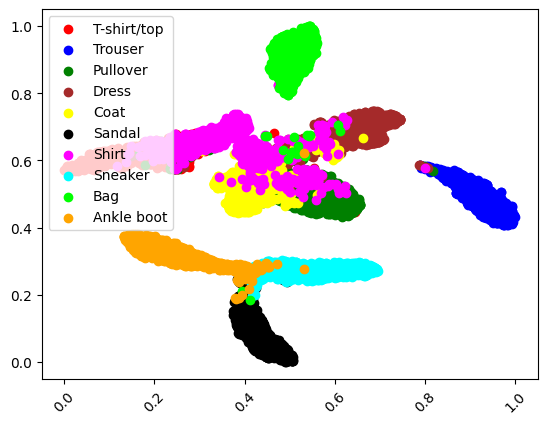

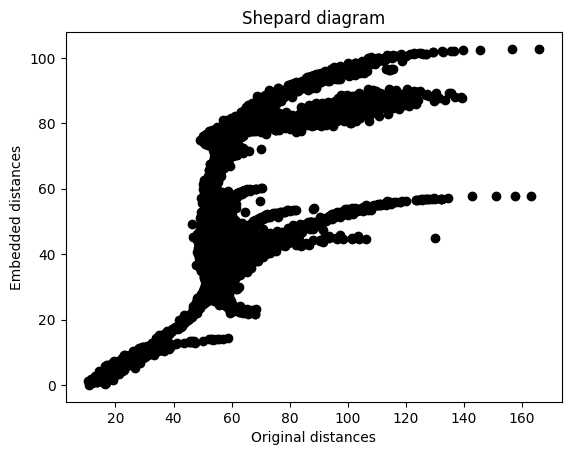

Computing normalized_stress
0.388403331962152
Computing shepard_goodness
0.6331135290853432
Computing SNS
0.38795314193588587
Computing Kruskal non-metric stress
0.3456987314812534
capture!


In [23]:
e.run()

In [24]:
#raise ValueError("Stop.")

In [25]:
del e
gc.collect()

24745

## Muffin vs Chihuahua

In [37]:
e = Experiment(muff_chiu_loading_params, 
               data_loader = Experiment.loader_folders_separate_test
                   ("/kaggle/input/muffin-vs-chihuahua-image-classification/test"),
              max_perceptual_layer=7,
              lr=1e-3)

 /kaggle/input/muffin-vs-chihuahua-image-classification/test/chihuahua				

Training set samples (shapes: ((4733, 160, 160, 3), (4733,)))


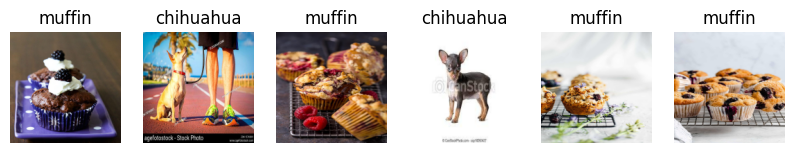

Test set samples (shapes: ((1184, 160, 160, 3), (1184,)))


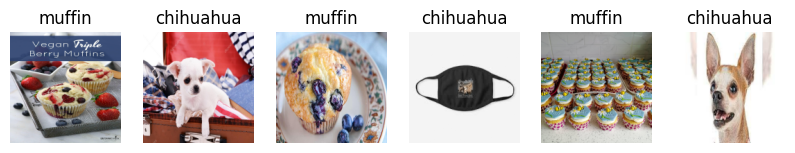

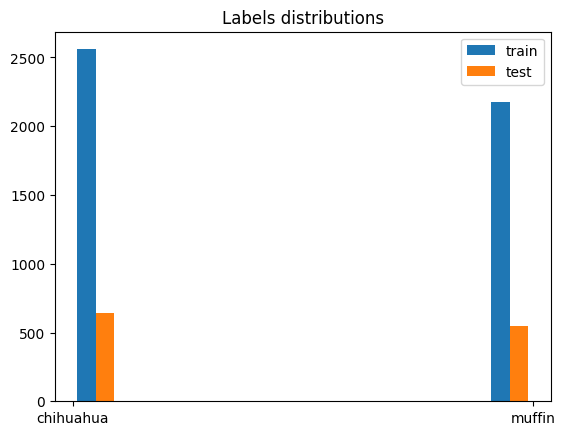

Running autoencoder


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 2048)           │    27,805,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │    27,815,283 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,620,707 (212.18 MB)

 Trainable params: 55,620,707 (212.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 58318.0391 - val_loss: 53204.1094
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 52018.8672 - val_loss: 52480.7812
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 51215.0312 - val_loss: 51020.5859
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 50125.6797 - val_loss: 49856.7109
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 49217.5352 - val_loss: 49336.5078
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 48405.4023 - val_loss: 48546.5859
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 47473.4727 - val_loss: 48083.5117
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 46538.0742 - val_loss: 47245.8516
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 46158.0039 - val_loss: 46541.7070
Epoch 10/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 45168.8750 - val_loss: 46171.2891


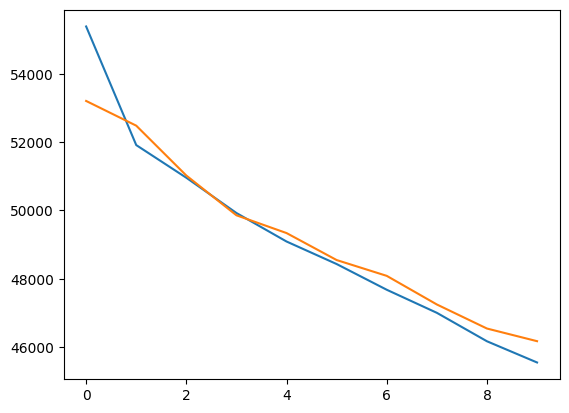

Autoencoder test samples:


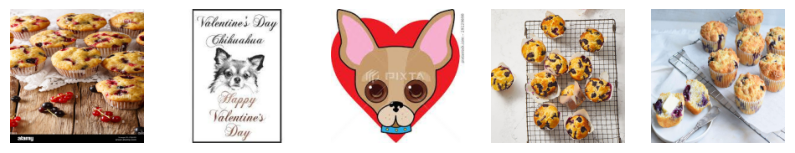

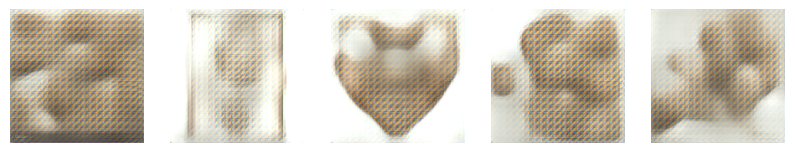

TSNE
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


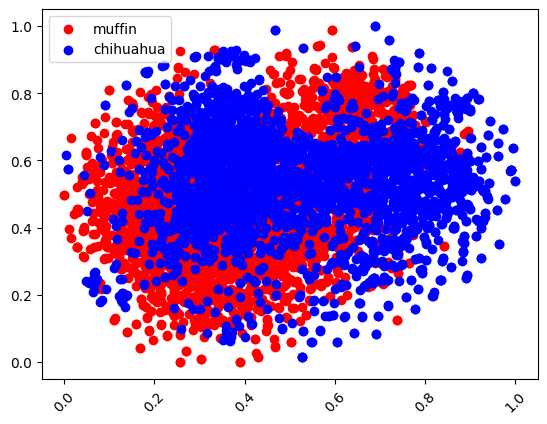

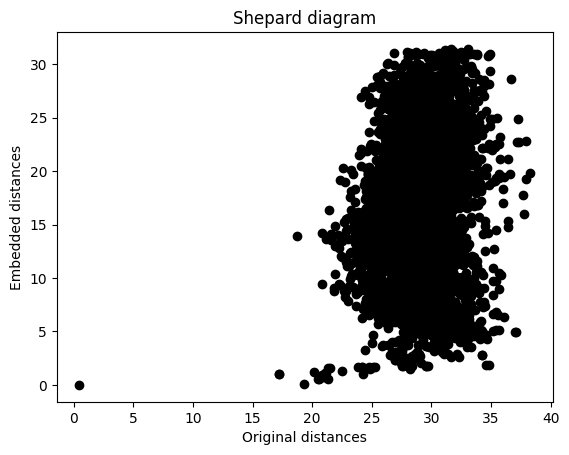

Computing normalized_stress
0.582275703569218
Computing shepard_goodness
0.5081617642067369
Computing SNS
0.4063925719197559
Computing Kruskal non-metric stress
0.39279141951700053
TSNE - VGG feedback
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step


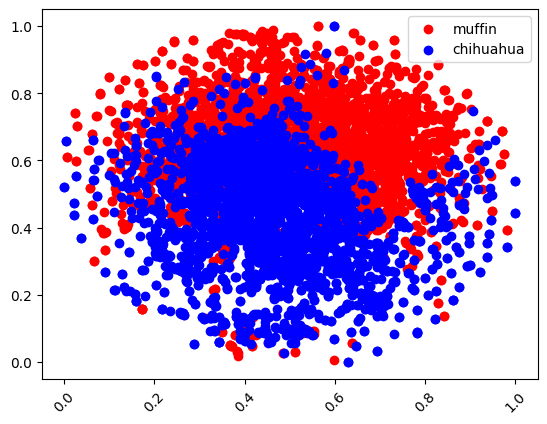

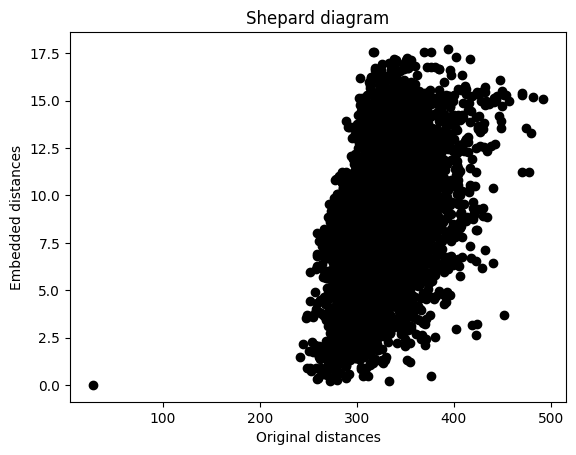

Computing normalized_stress
0.9778381147589948
Computing shepard_goodness
0.32684402632555054
Computing SNS
0.42915650327635657
Computing Kruskal non-metric stress
0.42554543815642465
Classification


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 160, 160, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │        25,602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,690 (6.11 MB)

 Trainable params: 1,600,690 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.6853 - loss: 0.5812 - val_accuracy: 0.8480 - val_loss: 0.3860
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8382 - loss: 0.3676 - val_accuracy: 0.8691 - val_loss: 0.3173
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8938 - loss: 0.2758 - val_accuracy: 0.8978 - val_loss: 0.2441
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9109 - loss: 0.2238 - val_accuracy: 0.9164 - val_loss: 0.2320
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9410 - loss: 0.1517 - val_accuracy: 0.8970 - val_loss: 0.2734
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9526 - loss: 0.1322 - val_accuracy: 0.9054 - val_loss: 0.2995
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9597 - loss: 0.1171 - val_accuracy: 0.9172 - val_loss: 0.2552
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9793 - loss: 0.0647 - val_acc

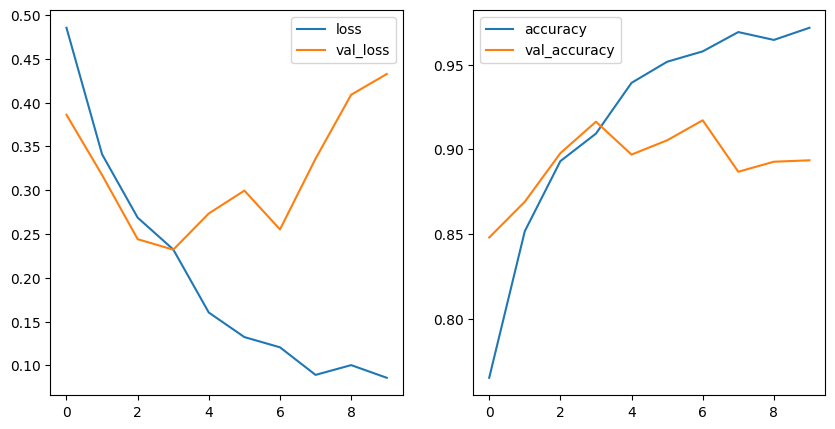

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


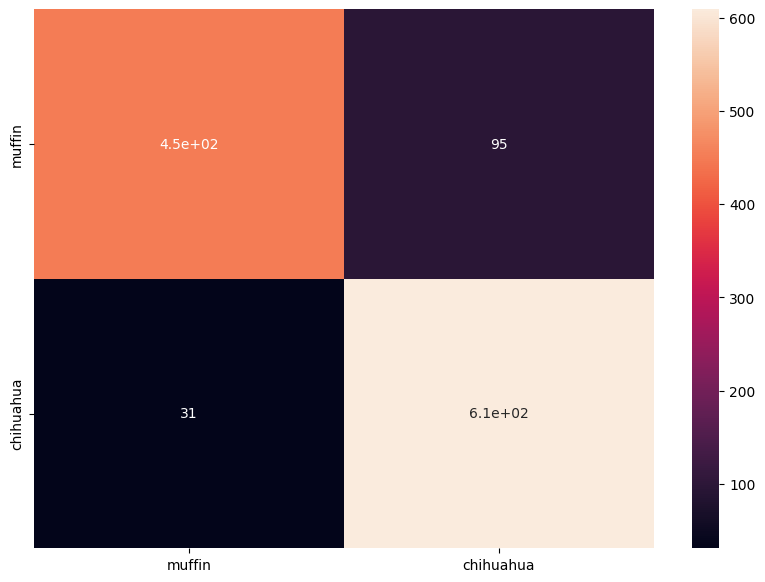

Classifier embeddings TSNE - train
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


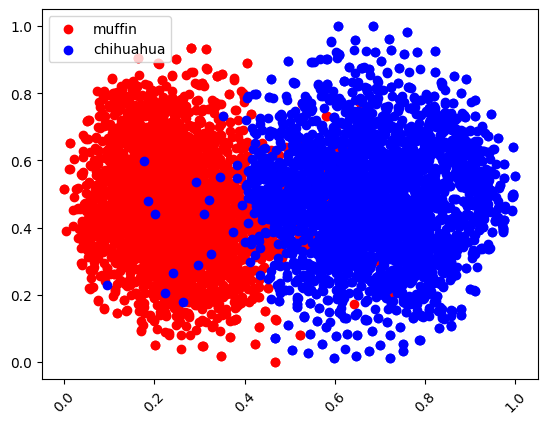

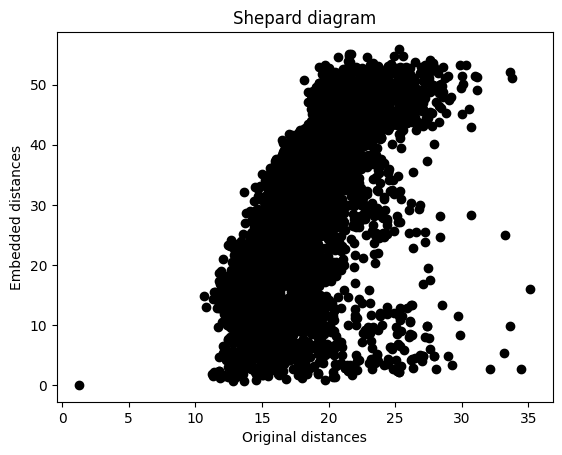

Computing normalized_stress
0.558274470913342
Computing shepard_goodness
0.5613655690565987
Computing SNS
0.4190981703020461
Computing Kruskal non-metric stress
0.4106693449649543
Classifier embeddings TSNE - test
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


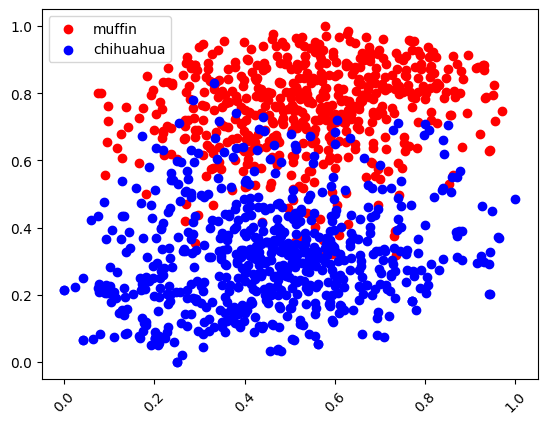

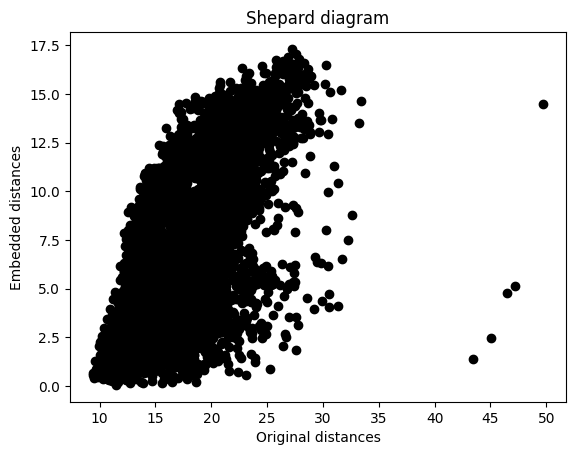

Computing normalized_stress
0.6172075767406676
Computing shepard_goodness
0.6077167652003389
Computing SNS
0.403119425862962
Computing Kruskal non-metric stress
0.3875955335857732


In [38]:
e.run()

In [39]:
del e
gc.collect()

25676

## Large Scale Fish Dataset

In [21]:
def fish_test_fix(x):
    angle=np.random.randint(0, 360)
    (h, w) = x.shape[:2]; center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated = cv2.warpAffine(x, M, (w, h))
    return rotated

In [22]:
e = Experiment(fish_loading_params, 
               data_loader = Experiment.loader_folders_separate_test
                   ("/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset", fish_test_fix),
              max_perceptual_layer=2, lr=1e-3)

 /kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Gilt Head Bream						am/Red Sea Bream GT													

Training set samples (shapes: ((9000, 192, 192, 3), (9000,)))


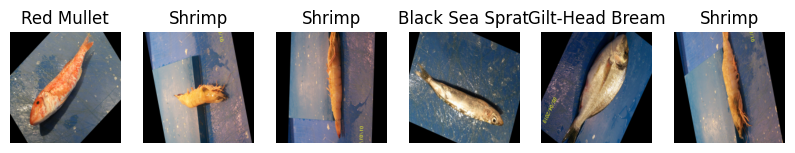

Test set samples (shapes: ((282, 192, 192, 3), (282,)))


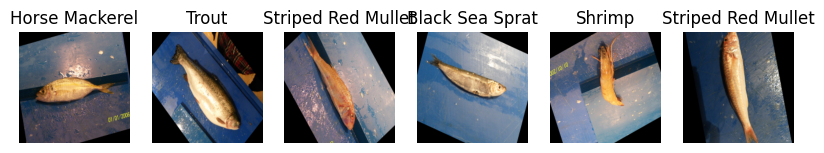

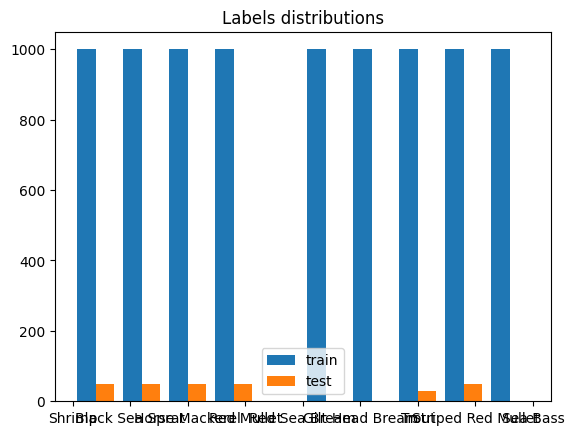

Running autoencoder
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 2048)           │    39,339,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 192, 192, 3)    │    39,355,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,695,011 (300.20 MB)

 Trainable params: 78,695,011 (300.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1731761486.320696      75 service.cc:145] XLA service 0x7b0fdc003000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731761486.320817      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1731761486.959921      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert/Assert
W0000 00:00:1731761486.960954      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_1/Assert
W0000 00:00:1731761486.961865      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_2/Assert
W0000 00:00:1731761486.962420      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_3/Assert


  2/563 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - loss: 1868.2012   

I0000 00:00:1731761497.068732      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1335.7325

W0000 00:00:1731761535.102907      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert/Assert
W0000 00:00:1731761535.103106      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_1/Assert
W0000 00:00:1731761535.103458      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_2/Assert
W0000 00:00:1731761535.103687      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_3/Assert


563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1335.4006

I0000 00:00:1731761541.156938      75 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_6', 72 bytes spill stores, 72 bytes spill loads

W0000 00:00:1731761542.590273      78 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert/Assert
W0000 00:00:1731761542.591433      78 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_1/Assert
W0000 00:00:1731761542.592196      78 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_2/Assert
W0000 00:00:1731761542.592847      78 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_3/Assert
W0000 00:00:1731761543.572149      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert/Assert
W0000 00:00:1731761543.572413      75 assert_op.cc:38] Ignoring Assert operator compile_loss/ae_loss/SSIM/Assert_1/Assert
W0000 00:00:1731761543.572843      75 assert_op.cc:38] Ignoring Assert

563/563 ━━━━━━━━━━━━━━━━━━━━ 65s 86ms/step - loss: 1335.0701 - val_loss: 824.9951
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - loss: 696.7848 - val_loss: 511.5593
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - loss: 477.7425 - val_loss: 445.8113
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 423.9432 - val_loss: 428.2763
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 395.2284 - val_loss: 425.8305
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 378.3958 - val_loss: 396.9663
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 357.5589 - val_loss: 382.5323
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 346.6075 - val_loss: 378.0662
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 338.2643 - val_loss: 366.9599
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 328.8011 - val_loss: 372.3844


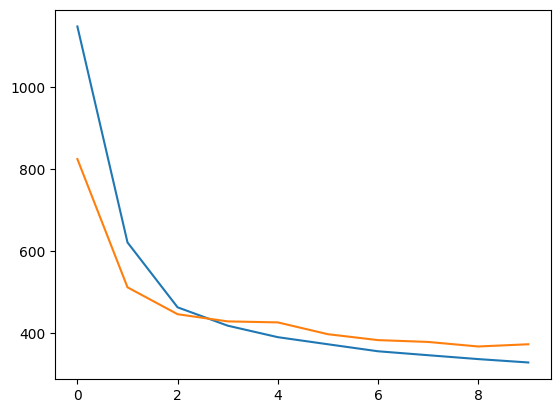

Autoencoder test samples:


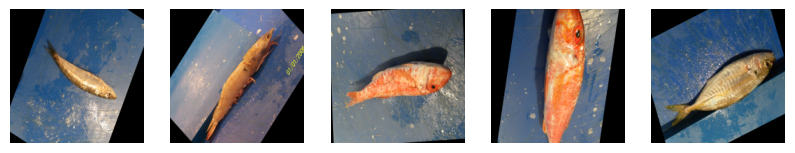

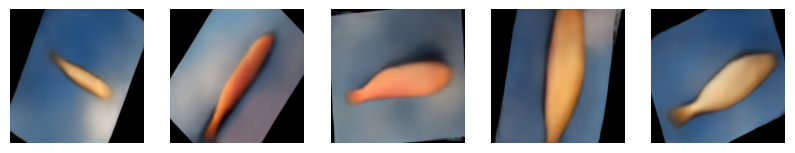

TSNE
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


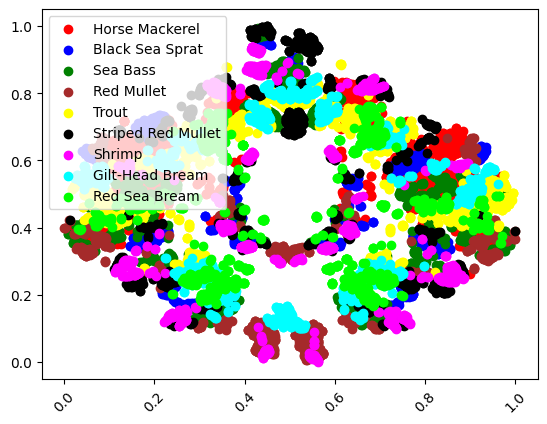

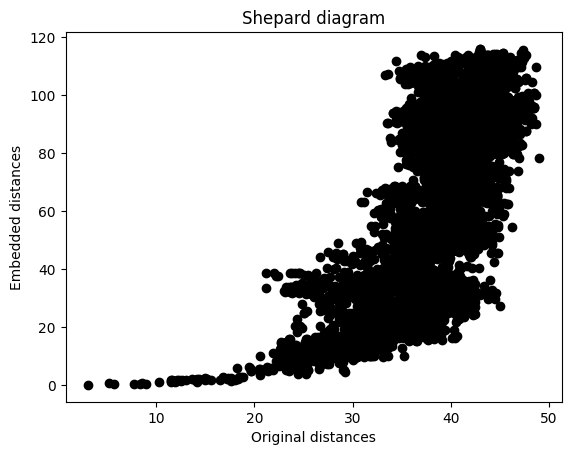

Computing normalized_stress
0.8448925344903178
Computing shepard_goodness
0.5431576348206677
Computing SNS
0.36848555965688917
Computing Kruskal non-metric stress
0.3338099001994866
TSNE - VGG feedback
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step


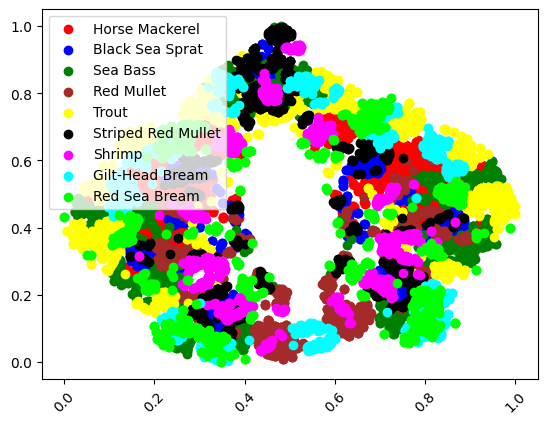

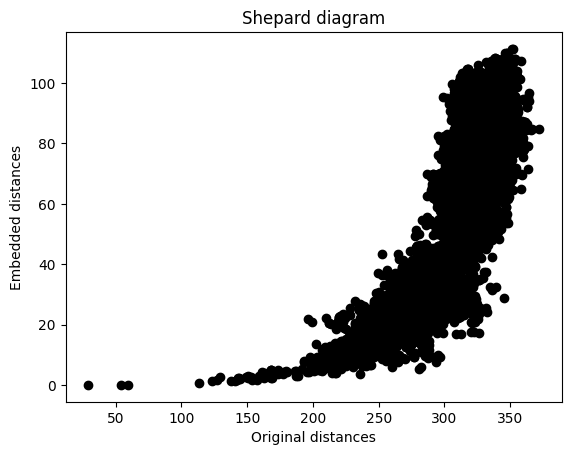

Computing normalized_stress
0.7918963428461959
Computing shepard_goodness
0.6626206851453869
Computing SNS
0.3717259540236441
Computing Kruskal non-metric stress
0.3011995176031545
Classification


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 192, 192, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 192, 192, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 96, 96, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │       165,897 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,740,985 (6.64 MB)

 Trainable params: 1,740,985 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.3183 - loss: 1.6832 - val_accuracy: 0.7801 - val_loss: 0.8205
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8030 - loss: 0.5481 - val_accuracy: 0.7801 - val_loss: 0.8063
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9222 - loss: 0.2447 - val_accuracy: 0.7518 - val_loss: 1.3916
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9625 - loss: 0.1146 - val_accuracy: 0.7553 - val_loss: 1.5144
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9550 - loss: 0.1575 - val_accuracy: 0.7943 - val_loss: 1.2235
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9694 - loss: 0.0977 - val_accuracy: 0.7695 - val_loss: 1.5181
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9789 - loss: 0.0842 - val_accuracy: 0.6950 - val_loss: 2.3023
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9488 - loss: 0.2055 - val_acc

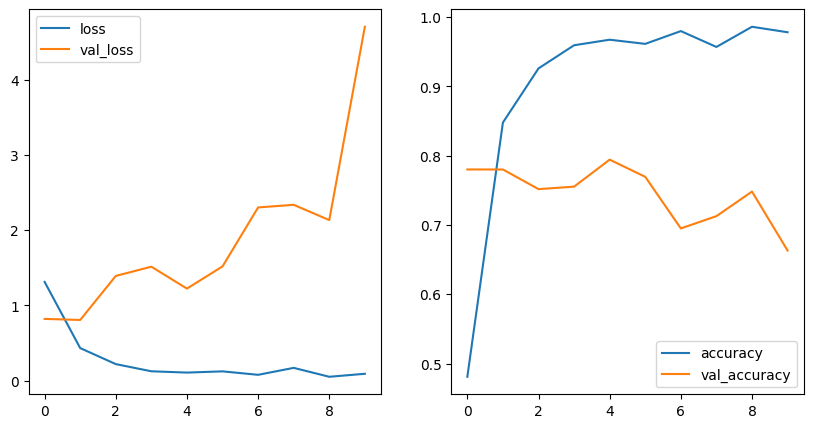

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


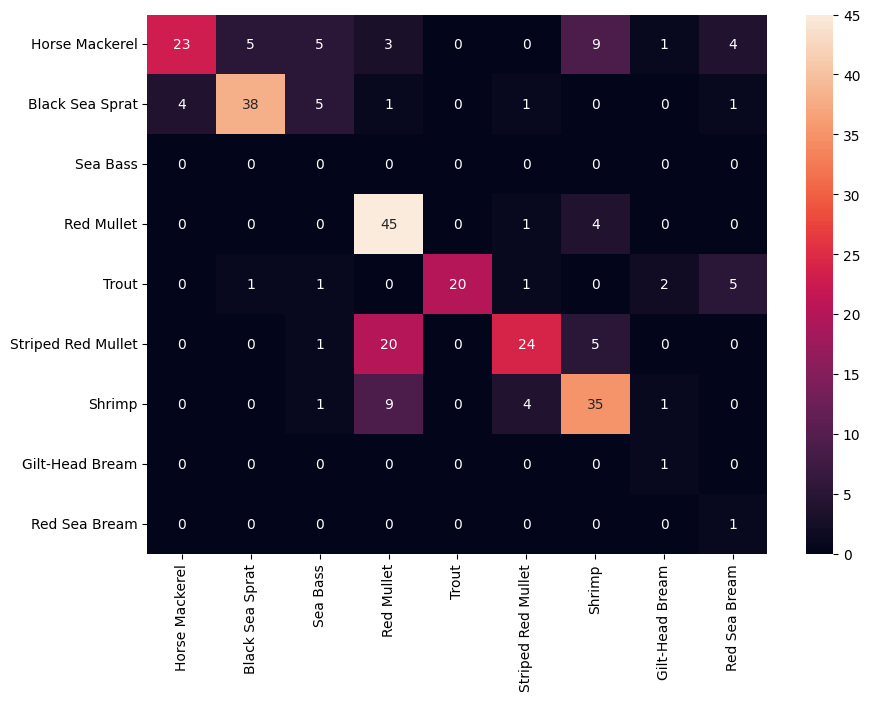

Classifier embeddings TSNE - train
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


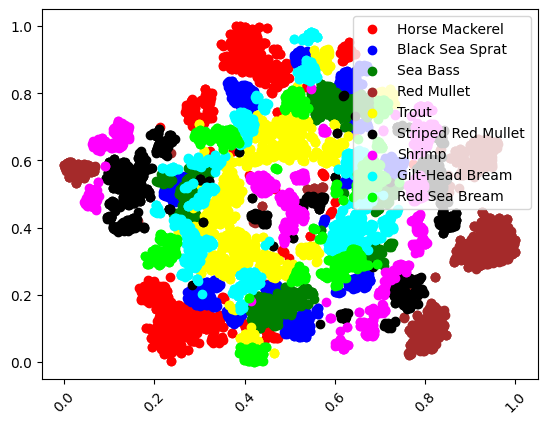

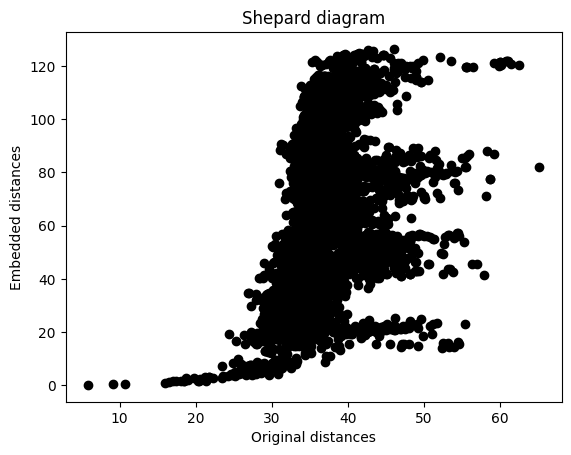

Computing normalized_stress
1.0561444938855038
Computing shepard_goodness
0.4176290509799042
Computing SNS
0.38736787596966504
Computing Kruskal non-metric stress
0.38410463511631726
Classifier embeddings TSNE - test
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


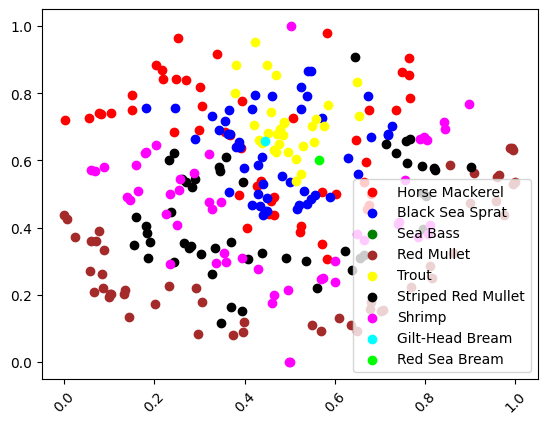

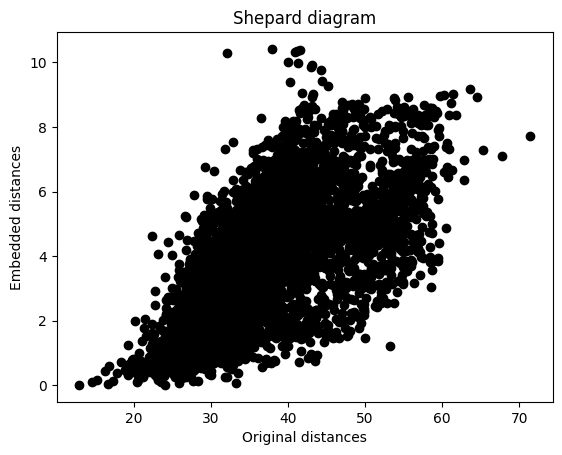

Computing normalized_stress
0.8909085079690257
Computing shepard_goodness
0.668270378738638
Computing SNS
0.3518365854039858
Computing Kruskal non-metric stress
0.32871495089530656


In [23]:
e.run()

In [24]:
del e
gc.collect()

26529